In the first we will import the necessary libraries of python which in this case pydicom and matplotlib.

In [1]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np

Now we will create a function to show the image present inside Dicom file. Since we are going to display images multiple times, we created a function of it.

In [2]:
def display_dicom(pixel_data):

    # Display the image
    plt.imshow(pixel_data, cmap='gray')
    plt.title('DICOM Image')
    plt.show()

Next we will create a function that will take the image data of dicom and convert it into k space.

In [3]:
def compute_kspace(pixel_data): 
    # Compute the k-space
    k_space = np.fft.fft2(pixel_data)
    k_space = np.fft.fftshift(k_space)
    return k_space

Next we will plot the k space through a function using plt.

In [4]:
def show_kspace(k_space):
    plt.imshow(np.log(np.abs(k_space)), cmap='gray')
    plt.title('k-Space')
    plt.show()

After that, we created a function where a square mask is applied to the center of the k space of the image obtained from Dicom.

In [5]:
def apply_mask_and_transform(k_space, mask_size):
    # Apply a square mask to the center of the k-space
    k_space_shape = k_space.shape
    mask = np.zeros(k_space_shape, dtype=bool)
    center_x = k_space_shape[0] // 2
    center_y = k_space_shape[1] // 2
    mask[center_x-mask_size//2:center_x+mask_size//2,
         center_y-mask_size//2:center_y+mask_size//2] = True
    k_space_masked = k_space * mask

    # Compute the inverse Fourier transform to obtain the image in the spatial domain
    image_data = np.fft.ifftshift(k_space_masked)
    image_data = np.fft.ifft2(image_data)
    image_data = np.abs(image_data)

    return image_data

In the next function, we basically implemented the inverse of same thing, applying mask on whole k space of image except for the center square.

In [6]:
def apply_mask_to_outer_k_space(k_space, mask_size):
    # Apply a square mask to the outer regions of the k-space
    k_space_shape = k_space.shape
    mask = np.ones(k_space_shape, dtype=bool)
    center_x = k_space_shape[0] // 2
    center_y = k_space_shape[1] // 2
    mask[center_x-mask_size//2:center_x+mask_size//2,
         center_y-mask_size//2:center_y+mask_size//2] = False
    k_space_masked = k_space * mask

    # Compute the inverse Fourier transform to obtain the image in the spatial domain
    image_data = np.fft.ifftshift(k_space_masked)
    image_data = np.fft.ifft2(image_data)
    image_data = np.abs(image_data)

    return image_data

The function remove_center(ds, img) takes in two arguments, a DICOM file ds and an image img. The purpose of the function is to remove a square region from the center of the image and replace it with a square of the same size filled with a constant value determined by the high bit of the DICOM file.

In [7]:
def remove_center(ds, img):
    # Determine the dimensions of the image
    height, width = img.shape

    high_bit= ds[0x00280102].value

    # Determine the dimensions of the square
    square_size = min(height, width) // 4

    # Determine the coordinates of the center of the image
    center_x, center_y = (width-square_size) // 2, (height-square_size) // 2
    square= np.ones((square_size,square_size))*(2**high_bit)

    # Draw the square on the new image
    img[center_y:center_y+square_size, center_x:center_x+square_size] = square
    
    return img

Now we will load the Dicom file, then extract the image data, and call the display_dicom to view the image, we will also compute the kspace and view that as well.

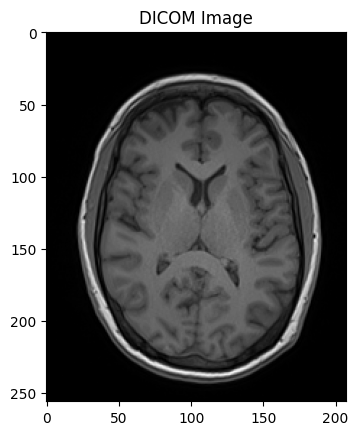

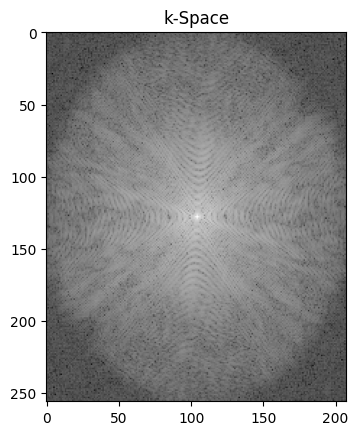

In [8]:
# Load the DICOM file
ds = pydicom.dcmread("t1.dcm")

# Extract the pixel data and convert to a numpy array
pixel_data = ds.pixel_array.astype(float)

display_dicom(pixel_data)
show_kspace(compute_kspace(pixel_data))

Now we will repeat the same stuff but this time, with the rotation of 90 degrees.

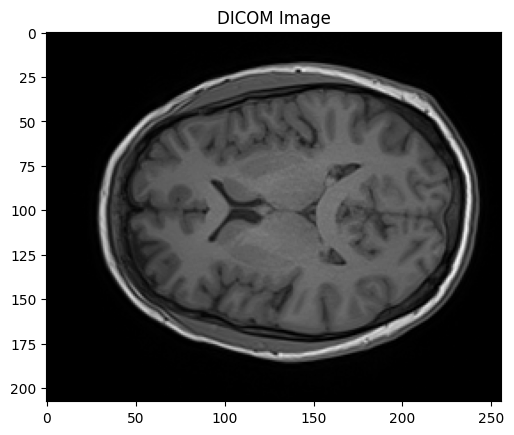

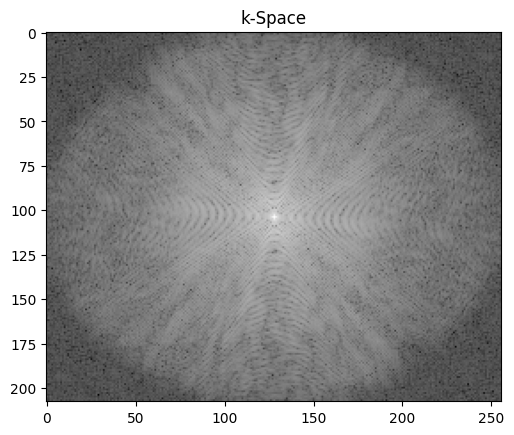

In [9]:
pixel_data_rotated = np.rot90(pixel_data)
display_dicom(pixel_data_rotated)
show_kspace(compute_kspace(pixel_data_rotated))

This time we will apply mask on the center of image's k space and then view it. we already defined its function above.

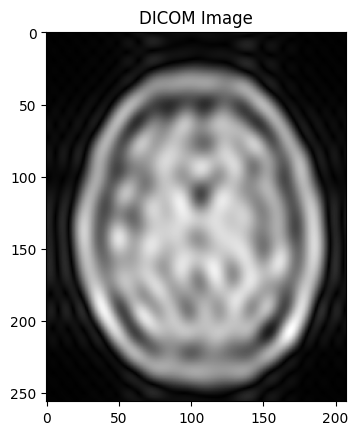

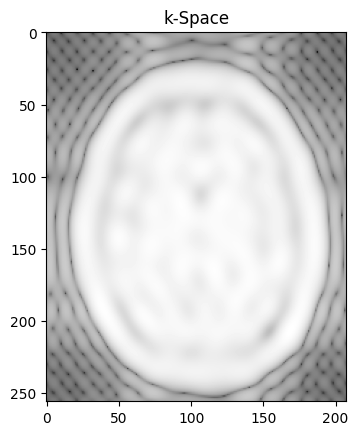

In [10]:
# remove center
inner = apply_mask_and_transform(compute_kspace(pixel_data), 20)
display_dicom(inner)
show_kspace(inner)

This time we will apply mask on the whole image's k space except for center and then observe it

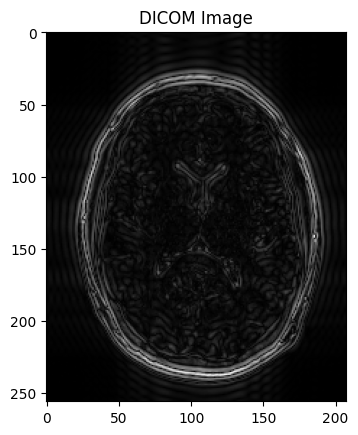

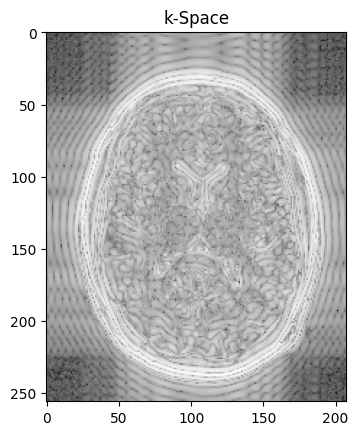

In [11]:
outer = apply_mask_to_outer_k_space(compute_kspace(pixel_data), 40)
display_dicom(outer)
show_kspace(outer)

In one of the task, we have to load an error file, perform an inverse Fourier transform on it, compute the magnitude of the resulting image data, and then display the image

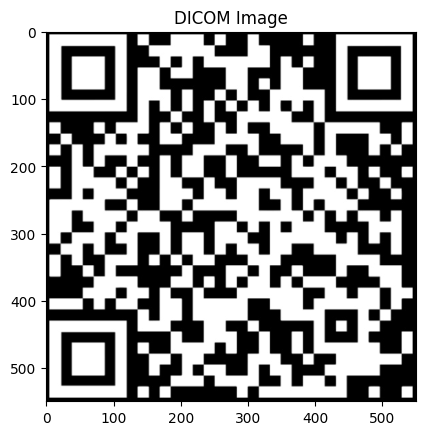

In [12]:
# Load the error data from file
error_data = np.load('error.npy')

# Compute the inverse Fourier transform to obtain the image in the spatial domain
image_data = np.fft.ifft2(error_data)

# Compute the magnitude of the image data (ignoring the imaginary part)
image_mag = np.abs(image_data)

# Display the image
display_dicom(image_mag)